## Import

In [1]:
main_folder = "./"
Model= 'resNet'
model_name="resNet"

In [2]:
import os
import copy
import itertools
import logging
import glob

from functools import partial
from datetime import datetime
from random import randint,shuffle

import tensorflow as tf
import numpy as np
from numpy import genfromtxt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt

## Data Utils

In [3]:

# 输入坐标进行去噪
# 使用Savitzky-Golay滤波器对坐标数据进行平滑处理，减小数据中的噪声

def denoise(coords, input_dim):
    stroke = savgol_filter(coords[:, 0], 7, 3, mode='nearest')
    for i in range(1, input_dim):
        x_new = savgol_filter(coords[:, i], 7, 3, mode='nearest')
        stroke = np.hstack([stroke.reshape(len(coords), -1), x_new.reshape(-1, 1)])
    return stroke



def denoise_all(stroke_all, input_dim):
    """
    smoothing filter to mitigate some artifacts of the data collection
    """
    stroke_new_all = []
    for coords in stroke_all:
        stroke = denoise(coords, input_dim)
        stroke_new_all.append(stroke)
    return stroke_new_all

#  时间变换，数据扩充

def time_warp(stroke, sigma=0.2):
    new_stroke = stroke.copy()
    time_steps = np.arange(stroke.shape[0])
    warped_time_steps = np.sort(np.random.normal(time_steps, sigma))
    for i in range(stroke.shape[1]):
        new_stroke[:, i] = np.interp(time_steps, warped_time_steps, stroke[:, i])
    return new_stroke


# 对坐标数据进行插值处理

def interpolate_all(stroke_all, max_x_length, input_dim):
    """
    interpolates strokes using cubic spline
    """
    coords_all = []
    for stroke in stroke_all:
        coords = interpolate(stroke, max_x_length, input_dim)
        coords_all.append(coords)
    return coords_all

def interpolate(stroke, max_x_length, input_dim):
    coords = np.zeros([input_dim, max_x_length], dtype=np.float32)
    if len(stroke) > 3:
        for j in range(input_dim):
            f_x = interp1d(np.arange(len(stroke)), stroke[:, j], kind='linear')
            xx = np.linspace(0, len(stroke) - 1, max_x_length)
            # xx = np.random.uniform(0,len(stroke)-1, max_x_length)
            x_new = f_x(xx)
            coords[j, :] = x_new
    coords = np.transpose(coords)
    return coords



# 扩充数据和标签

def multiplier(data,label,multi):
    data_ = data
    label_ = label
    for i in range(multi):
        data_ = np.concatenate((data_, data))
        label_ = np.concatenate((label_, label))

    data = data_
    label = label_

    return data,label

# 打乱数据和标签

def shuffle(data,label):
    data = np.asarray(data,dtype = object)
    shuffled_indexes = np.random.permutation(np.shape(data)[0])
    data = data[shuffled_indexes]
    label = label[shuffled_indexes]
    return data, label



# 读取并处理新的手势数据

def get_new_gesture_data(path,max_length,input_dim, data_synthesis = False):
    new_gesture_list = []

    for i, fname in enumerate(sorted(glob.glob(path))):
        new_gesture = genfromtxt(fname, delimiter=',')
        #     new_gesture = denoise(new_gesture,input_dim)
        new_gesture = interpolate(new_gesture, max_length, input_dim)
        new_gesture_list.append(new_gesture)

    if data_synthesis:
        synthetic_data = np.load('synthetic_data/synthetic_data.npy', allow_pickle=True)
        new_gesture_list = np.concatenate((new_gesture_list, synthetic_data))
    new_label_list = np.ones(len(new_gesture_list)) * 11
    new_gesture_list , new_label_list = shuffle(new_gesture_list,new_label_list)
    return new_gesture_list , new_label_list

# 划分训练集和测试集，扩充数据
def train_test_split(data,label,new_gesture_list,new_label_list,split_num):

    for _ in range(10):
        data, label =  shuffle(data, label)

    train_data, test_data = np.split(
        data, [np.shape(data)[0] * 9 // 10]
    )
    train_label, test_label = np.split(
        label, [np.shape(label)[0] * 9 // 10]
    )
    multi = 10

    train_data = np.concatenate((train_data,new_gesture_list[:split_num]))
    train_label = np.concatenate((train_label,new_label_list[:split_num]))
    train_data, train_label = multiplier(train_data, train_label, multi)

    test_data = np.concatenate((test_data,new_gesture_list[split_num:]))
    test_label = np.concatenate((test_label,new_label_list[split_num:]))
    test_data, test_label = multiplier(test_data, test_label, multi)

    train_data, train_label = shuffle(train_data, train_label)

    test_data, test_label = shuffle(test_data, test_label)

    train_data = np.asarray(train_data, dtype=np.float32)
    test_data = np.asarray(test_data, dtype=np.float32)

    train_label = np.asarray(train_label, dtype=np.int32)
    test_label = np.asarray(test_label, dtype=np.int32)

    return train_data, train_label, test_data, test_label


def train_test_split_2(data, label, new_gesture_list, new_label_list, split_num):
    for _ in range(10):
        data, label = shuffle(data, label)

    train_data, test_data = np.split(data, [np.shape(data)[0] * 9 // 10])
    train_label, test_label = np.split(label, [np.shape(label)[0] * 9 // 10])
    multi = 10

    augmented_data = []
    augmented_labels = []

    for gesture in new_gesture_list[:split_num]:
        augmented_data.append(gesture)
        augmented_data.append(time_warp(gesture))  # 添加时间变换


    train_data = np.concatenate((train_data, augmented_data))
    train_label = np.concatenate((train_label, np.tile(new_label_list[:split_num], multi)))  # 注意这里是 tile 而不是 repeat
    train_data, train_label = multiplier(train_data, train_label, multi)

    test_data = np.concatenate((test_data, new_gesture_list[split_num:]))
    test_label = np.concatenate((test_label, new_label_list[split_num:]))
    test_data, test_label = multiplier(test_data, test_label, multi)

    train_data, train_label = shuffle(train_data, train_label)
    test_data, test_label = shuffle(test_data, test_label)

    train_data = np.asarray(train_data, dtype=np.float32)
    test_data = np.asarray(test_data, dtype=np.float32)
    
    print(f"Training data size: {train_data.shape[0]}")
    print(f"Testing data size: {test_data.shape[0]}")

    train_label = np.asarray(train_label, dtype=np.int32)
    test_label = np.asarray(test_label, dtype=np.int32)

    return train_data, train_label, test_data, test_label


def confusion_matrix(save_path,new_gesture):
    cm = np.load(save_path + '/confusion_matrix.npy')

    classes = ['still', 'ticktock', 'shrink', 'push', 'peaceout', 'madriddles',
               'grow', 'flamingo', 'execution', 'cheshiredance', 'caterpillar', new_gesture]

    target_names = list(classes)
    title = 'Confusion matrix'
    cmap = None
    normalize = True

    accuracy = np.trace(cm) / float(np.sum(cm))
    # np.save(SAVE_PATH+ 'confusion_matrix.npy',cm)
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    # plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title, fontsize=30)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90, fontsize=20)
        plt.yticks(tick_marks, target_names, fontsize=20)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 10 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.imshow(cm, cmap=cmap)
    # plt.grid(None)
    plt.tight_layout()
    # plt.ylabel('True label', fontsize=50)
    # plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=30)
    # plt.show()
    plt.savefig('confusion_matrix.pdf')
    # plt.close()


# 模型选择
    
def model_selection(Model,drop_out,max_length,input_dim ,output_dim):
    model = ''

    if Model == 'rnn_att_model':
        model = rnn_att_model(max_length,
                          input_dim,
                          output_dim,dropout=drop_out)

    if Model == 'resNet_LSTM':
        model = resNet_LSTM(max_length,
                          input_dim,
                          output_dim,dropout=drop_out)

    elif Model == 'resNet':
        model = resNet(max_length,
                          input_dim,
                          output_dim)
    elif Model == 'cnnModel':
        model = cnnModel(max_length,
                          input_dim,
                          output_dim)
    elif Model == 'Inception':
        model = Inception(max_length,
                          input_dim,
                          output_dim)
    elif Model == 'smallCnnModel':
        model = smallCnnModel(max_length,
                          input_dim,
                          output_dim)

    elif Model == 'LSTM_RES':
        model = LSTM_RES(max_length,
                          input_dim,
                          output_dim,dropout=drop_out)

    return  model


def init_logging(log_dir, Model):
    logging_level = logging.INFO

    log_file = 'log_{}.txt'.format(Model)

    log_file = os.path.join(log_dir, log_file)
    if os.path.isfile(log_file):
        os.remove(log_file)

    logging.basicConfig(
        filename=log_file,
        level=logging_level,
        format='[[%(asctime)s]] %(message)s',
        datefmt='%m/%d/%Y %I:%M:%S %p'
    )
    logging.getLogger().addHandler(logging.StreamHandler())

    return logging


## Data Handling

In [4]:
def read_shrec_2021(path):
    gesture_data = []
    sequence_idx_list = []

    for i, fname in enumerate(sorted(glob.glob(path))):
        # print(fname)

        idx = fname.split('/')[-1].split('.')[0]
        # print(idx)

        data = genfromtxt(fname, delimiter=';')
        data_ = np.delete(data, -1, axis=1)
        gesture_data.append(data_)
        sequence_idx_list.append(int(idx))

    gesture_data_sorted = [x for _, x in sorted(zip(sequence_idx_list, gesture_data))]

    return gesture_data_sorted

def read_annotation(fname_,gesture_data,max_length = 80):
    gesture_name = ['ONE','TWO','THREE','FOUR','OK','MENU', 'LEFT',
                    'RIGHT','CIRCLE','V','CROSS','GRAB','PINCH','TAP','DENY', 'KNOB','EXPAND']
    with open(fname_) as f:
        lines = f.readlines()

    gesture_name_list = []
    start_idx_list = []
    end_idx_list = []
    annotation_idx_list = []
    for i in range(len(lines)):

        gesture_name_list.append(lines[i].split(';')[1:-1][::3])
        start_idx_list.append(lines[i].split(';')[2:-1][::3])
        end_idx_list.append(lines[i].split(';')[0:-1][::3][1:])
        annotation_idx_list.append(int(lines[i].split(';')[0]))

    gesture_name_list = [x for _, x in sorted(zip(annotation_idx_list, gesture_name_list))]
    start_idx_list = [x for _, x in sorted(zip(annotation_idx_list, start_idx_list))]
    end_idx_list = [x for _, x in sorted(zip(annotation_idx_list, end_idx_list))]


    single_gesture = []
    gesture_class = []

    for i in range(len(gesture_data)):
        for j in range(len(gesture_name_list[i])):
            start_idx = int(start_idx_list[i][j])
            end_idx = int(end_idx_list[i][j])
            single_gesture.append(gesture_data[i][start_idx:start_idx+max_length])
            gesture_class.append(gesture_name.index(gesture_name_list[i][j]))

    return single_gesture, gesture_class

def pad_data(input_dim, data,max_length):
    data_padded = np.zeros([len(data),max_length,input_dim])
    for i in range(len(data)):
        if len(data[i]) <= max_length:
            data_padded[i,:len(data[i])] = data[i]
        if len(data[i]) > max_length:
            data_padded[i] = data[i][:max_length]
    return data_padded

def select_joint(selected_joint,gesture_data,pos = True, quat= True):
    split_joint_name = ['palm', 'thumbA', 'thumbB', 'thumbEnd', 'indexA', 'indexB', 'indexC', 'indexEnd', 'middleA', 'middleB', 'middleC', 'middleEnd', 'ringA', 'ringB', 'ringC', 'ringEnd', 'pinkyA', 'pinkyB', 'pinkyC', 'pinkyEnd']

    selected_joint_idx = []
    for x in selected_joint:
        selected_joint_idx.append(split_joint_name.index(x))

    idx_list_pos_x = np.multiply(selected_joint_idx,7)
    idx_list_pos_y = np.multiply(selected_joint_idx,7)+1
    idx_list_pos_z = np.multiply(selected_joint_idx,7)+2
    idx_list_quat_x = np.multiply(selected_joint_idx,7)+3
    idx_list_quat_y = np.multiply(selected_joint_idx,7)+4
    idx_list_quat_z = np.multiply(selected_joint_idx,7)+5
    idx_list_quat_w = np.multiply(selected_joint_idx,7)+6

    idx_list_pos = np.concatenate([idx_list_pos_x,idx_list_pos_y,idx_list_pos_z])
    idx_list_quat = np.concatenate([idx_list_quat_x,idx_list_quat_y,idx_list_quat_z,idx_list_quat_w])


    if pos:
        data = gesture_data[:,sorted(idx_list_pos)]
    if quat:
        data = gesture_data[:,sorted(idx_list_quat)]
    if pos and quat:
        data = gesture_data[:,sorted(np.concatenate([idx_list_pos,idx_list_quat]))]

    return data

def preprocess(data, xlist = [0, 3, 6, 9, 12, 15],nor_to_wrist=False, relative=False):
    # relative replacement or not
    # use center as track or not, if not, use wrist as track
    length = np.shape(data)[0]
    input_dim = np.shape(data)[1]

    if relative:
        if nor_to_wrist:
            data = nortowrist(data, xlist)
            data = relative_track_batch(length, input_dim, data)
        else:
            data = relative_track_batch(length, input_dim, data)
    elif not relative:
        if nor_to_wrist:
            data = nortowrist(data, xlist)
        else:
            data = data

    return data

def relative_track_batch(length, input_dim, data):
    ### do this every iteration to make first step replacement=0
    temp = data[:, 0:input_dim]
    lastplace = np.zeros([length, 1])
    # x
    lastplace[1: length, 0] = temp[0: length - 1, 0]
    lastplace[0, 0] = temp[0, 0]
    temp[0: length, 0] -= lastplace[:, 0]
    # y
    lastplace[1: length, 0] = temp[0: length - 1, 1]
    lastplace[0, 0] = temp[0, 1]
    temp[0: length, 1] -= lastplace[:, 0]
    # z
    lastplace[1: length, 0] = temp[0: length - 1, 2]
    lastplace[0, 0] = temp[0, 2]
    temp[0: length, 2] -= lastplace[:, 0]
    temp = np.reshape(temp, [length, input_dim])
    return temp


def nortowrist(data, xlist):
    ###### normalize to wrist
    ylist = np.add(xlist, 1)
    zlist = np.add(xlist, 2)

    xc = data[:, 0]
    yc = data[:, 1]
    zc = data[:, 2]
    data[:, xlist] -= np.tile(
        np.reshape(xc, [-1, 1]), (1, len(xlist)))
    data[:, ylist] -= np.tile(
        np.reshape(yc, [-1, 1]), (1, len(ylist)))
    data[:, zlist] -= np.tile(
        np.reshape(zc, [-1, 1]), (1, len(zlist)))

    return data



In [5]:
def tfdata(train_data, train_label, test_data, test_label, batch_size):


    trainData =  tf.data.Dataset.from_tensor_slices(
        (train_data, train_label)
    )
    trainData = trainData.shuffle(buffer_size=np.shape(train_data)[0])
    trainData = trainData.batch(batch_size).prefetch(buffer_size=1)
    trainsteps = np.shape(train_data)[0] // batch_size

    testData =  tf.data.Dataset.from_tensor_slices(
        (test_data, test_label)
    )
    testData = testData.shuffle(buffer_size=np.shape(test_data)[0])
    testData = testData.batch(batch_size).prefetch(buffer_size=1)
    teststeps = np.shape(test_data)[0] // batch_size

    return trainData,trainsteps, testData, teststeps


def getDataTest(test_data, test_label, batch_size):

    testData =  tf.data.Dataset.from_tensor_slices(
        (test_data, test_label)
    )

    testData = testData.batch(batch_size).prefetch(buffer_size=1)
    teststeps = np.shape(test_data)[0] // batch_size

    return testData, teststeps, test_data, test_label



## Training Function Implementation

In [6]:
import pickle
import matplotlib.pyplot as plt

class LrLogger(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.lrs = []

    def on_epoch_end(self, epoch, logs=None):
        self.lrs.append(self.model.optimizer.lr.numpy())

def train_classifier(model, Model, SAVE_PATH, EPOCHS, learning_rate, train_data, train_label, test_data, test_label, batch_size):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["sparse_categorical_accuracy"])
    model.summary()

    SAVE_PATH_model = SAVE_PATH + 'Model/'

    trainData, trainsteps, validData, validsteps = tfdata(train_data, train_label, test_data, test_label, batch_size)

    # Stop if the validation accuracy doesn't improve for x epochs
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=2)

    # You can remove or comment out the reduceLR callback if you don't want the learning rate to change
    reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=2)

    lr_logger = LrLogger()

    history_lstm = model.fit(trainData.repeat(),
                             steps_per_epoch=trainsteps,
                             validation_data=validData.repeat(),
                             validation_steps=validsteps,
                             epochs=EPOCHS,
                             callbacks=[earlyStopping, reduceLR, lr_logger])

    # Save model
    model.save(SAVE_PATH_model)

    # Save training history
    with open(SAVE_PATH_model + "train_results.pickle", "wb") as handle:
        pickle.dump(history_lstm.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Saved training history to res")

    # Plot training & validation accuracy and loss
    plot_metrics(history_lstm.history, lr_logger.lrs)

def plot_metrics(history, lrs):
    epochs = range(1, len(history['sparse_categorical_accuracy']) + 1)
    if 'Times New Roman' in plt.rcParams['font.family']:
        plt.rcParams['font.family'] = 'Times New Roman'
    else:
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = 'Times New Roman'
    
    plt.figure(figsize=(21, 6))
    
    # Plot accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['sparse_categorical_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f"{model_name}_Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)
    
    # Plot loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"{model_name}_Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    
    # Plot learning rate
    plt.subplot(1, 3, 3)
    plt.plot(epochs, lrs, label='Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title(f"{model_name}_Learning Rate on Validation")
    plt.legend()
    plt.grid(True)
    
    
    
    plt.tight_layout()
    
    plt.savefig(f"{model_name}_model_performance.png")  # 设置你想要的图片名称  
    plt.show()

## Model Implementations

In [7]:
'''
Models implementations
'''
def cnnModel(input_shape1,
                input_shape2,
                  output_shape):

    input_shape = (input_shape1, input_shape2)
    model = tf.keras.models.Sequential()

    # Normalization layer
    model.add(tf.keras.layers.Reshape(input_shape=input_shape, target_shape=(input_shape1, input_shape2, 1)))
    model.add(tf.keras.layers.BatchNormalization())

    filters = [16, 32, 64, 128]

    for num_filters in filters:
        # Conv a
        model.add(tf.keras.layers.Conv2D(
            num_filters,
            kernel_size=(3, 3),
            padding='same'
            )
        )
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))

        # Conv b
        model.add(tf.keras.layers.Conv2D(
            num_filters,
            kernel_size=(3, 3),
            padding='same'
            )
        )
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))

        # Pooling
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.2))

    # Classification layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, name='features512'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(256, name='features256'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(output_shape, activation='softmax'))

    return model


def smallCnnModel(input_shape1,
                input_shape2,
                  output_shape):


    input_shape = (input_shape1, input_shape2)

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Reshape(input_shape=input_shape, target_shape=(input_shape1, input_shape2, 1)))

    model.add(tf.keras.layers.Convolution2D(32, (1, 10), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(64, (1, 5), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D((1, 4)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Convolution2D(64, (1, 10), padding='valid', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(128, (10, 1), padding='same', activation='relu'))

    model.add(tf.keras.layers.GlobalMaxPool2D())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(128, activation='relu', name='FEATURES'))
    model.add(tf.keras.layers.Dense(output_shape, activation='softmax'))

    return model


def modular_cnn_model(input_shape=(300, 18)):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Reshape(
        input_shape=input_shape, target_shape=(input_shape[0], input_shape[1], 1)))

    model.add(tf.keras.layers.Convolution2D(
        32, (1, 5), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(
        64, (1, 5), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((1, 4)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Convolution2D(
        64, (1, 5), padding='valid', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(
        128, (5, 1), padding='same', activation='relu'))

    model.add(tf.keras.layers.GlobalMaxPooling2D())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(128, activation='relu', name='FEATURES'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    return model


class inceptionModule(tf.keras.layers.Layer):
    def __init__(self, n):
        super(inceptionModule,self).__init__()
        self.n = n
    def __call__(self, x_input):

        # Conv 1x1
        conv_1x1 = tf.keras.layers.Conv2D(self.n, (1, 1), padding='same', activation='relu')(x_input)

        # Conv 3x3
        conv_3x3 = tf.keras.layers.Conv2D(self.n, (1, 1), padding='same', activation='relu')(x_input)
        conv_3x3 = tf.keras.layers.Conv2D(self.n, (3, 3), padding='same', activation='relu')(conv_3x3)

        # Conv 5x5
        conv_5x5 = tf.keras.layers.Conv2D(self.n, (1, 1), padding='same', activation='relu')(x_input)
        conv_5x5 = tf.keras.layers.Conv2D(self.n, (3, 3), padding='same', activation='relu')(conv_5x5)

        # pool + proj
        pool = tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x_input)
        pool = tf.keras.layers.Conv2D(self.n, (1, 1), padding='same', activation='relu')(pool)

        output = tf.keras.layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool], axis=3)

        return output



def Inception(input_shape1,
                input_shape2,
                  output_shape):


    input_shape = (input_shape1, input_shape2)
    input_layer = tf.keras.layers.Input(input_shape)

    reshape_layer = tf.keras.layers.Reshape(target_shape=(input_shape1, input_shape2, 1))(input_layer)

    x = tf.keras.layers.Conv2D(32, (6, 4), padding='same', strides=(2, 2), activation='relu')(reshape_layer)
    x = tf.keras.layers.MaxPooling2D((3, 2), padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)


    x = inceptionModule(32)(x)
    x = inceptionModule(64)(x)
    x = tf.keras.layers.MaxPooling2D((3, 2))(x)

    x = inceptionModule(64)(x)
    x = inceptionModule(128)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)

    x = tf.keras.layers.Dense(output_shape, activation='softmax')(x)

    model = tf.keras.Model(inputs=[input_layer], outputs=[x])
    return model


class residualModule(tf.keras.layers.Layer):
    def __init__(self, n_filters):
        super(residualModule,self).__init__()
        self.n_filters = n_filters
        self.merge_input = tf.keras.layers.Conv2D(
                self.n_filters, (1, 1), padding='same',
                activation='relu',
                kernel_initializer='he_normal')
        self.conv1 = tf.keras.layers.Conv2D(
            self.n_filters, (3, 3), padding='same',
            activation='relu',
            kernel_initializer='he_normal')
        self.conv2 = tf.keras.layers.Conv2D(
            self.n_filters, (3, 3), padding='same',
            activation='linear',
            kernel_initializer='he_normal')
        self.BatchNormalization = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()

    def __call__(self, layer_in):
        merge_input = layer_in
        # check if the number of filters needs to be increased
        if layer_in.shape[-1] != self.n_filters:
            merge_input = self.merge_input(layer_in)

        conv1 = self.conv1(layer_in)
        conv2 = self.conv2(conv1)

        # add filters
        layer_out = self.add([conv2, merge_input])
        layer_out = self.BatchNormalization(layer_out)
        layer_out = self.activation(layer_out)

        return layer_out



def resNet(input_shape1,
                input_shape2,
                  output_shape):

    input_shape = (input_shape1, input_shape2)

    input_layer = tf.keras.Input(shape=input_shape)

    reshape_layer = tf.keras.layers.Reshape(input_shape=input_shape, target_shape=(input_shape1, input_shape2, 1))(input_layer)

    x = tf.keras.layers.Conv2D(64, (6, 4), padding='same', strides=(2, 2), activation='relu')(reshape_layer)
    x = tf.keras.layers.MaxPool2D((3, 2), padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = residualModule(64)(x)
    x = residualModule(128)(x)
    x = tf.keras.layers.MaxPool2D((3, 2))(x)

    x = residualModule(128)(x)
    x = residualModule(256)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Dense(512, activation='relu')(x)

    x = tf.keras.layers.Dense(output_shape, activation='softmax')(x)

    model = tf.keras.Model(inputs=[input_layer], outputs=[x])
    return model


def rnn_att_model(input_shape1,
                input_shape2,
                  output_shape,
                  cnn_features=10,
                  rnn='LSTM',
                  multi_rnn=True,
                  attention=True,
                  dropout=0.2):

    # Fetch input
    input_shape = (input_shape1, input_shape2)
    inputs = tf.keras.Input(shape=input_shape)
    # reshape = tf.keras.layers.Reshape(
    #     input_shape=input_shape, target_shape=(input_shape1, input_shape2, 1))(inputs)
    # # Normalization Layer
    # layer_out = tf.keras.layers.BatchNormalization()(reshape)
    #
    # # Convolutional Layer
    # layer_out = tf.keras.layers.Conv2D(cnn_features, kernel_size=(3, 3),
    #                                    padding='same', activation='relu')(layer_out)
    # layer_out = tf.keras.layers.BatchNormalization()(layer_out)
    # layer_out = tf.keras.layers.Conv2D(1, kernel_size=(3, 3),
    #                                    padding='same', activation='relu')(layer_out)
    # layer_out = tf.keras.layers.BatchNormalization()(layer_out)
    # layer_out = tf.keras.layers.Lambda(
    #     lambda x: tf.keras.backend.squeeze(x, -1), name='squeeze_dim')(layer_out)

    # LSTM Layer
    if rnn not in ['LSTM', 'GRU']:
        raise ValueError(
            'rnn should be equal to LSTM or GRU. No model generated...')

    if rnn == 'LSTM':
        layer_out = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
            400, return_sequences=True, dropout=dropout))(inputs)
        if multi_rnn:
            layer_out = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
                400, return_sequences=True, dropout=dropout))(layer_out)

    # GRU Layer
    if rnn == 'GRU':
        layer_out = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(
            400, return_sequences=True, dropout=dropout))(inputs)
        if multi_rnn:
            layer_out = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(
                400, return_sequences=True, dropout=dropout))(layer_out)

    # Attention Layer
    if attention:
        query, value = tf.keras.layers.Lambda(
            lambda x: tf.split(x, num_or_size_splits=2, axis=2))(layer_out)
        layer_out = tf.keras.layers.Attention(name='Attention')([query, value])

    # Classification Layer
    outputs = tf.keras.layers.Flatten()(layer_out)
    outputs = tf.keras.layers.Dense(512, activation='relu')(outputs)
    outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(outputs)

    # Output Model
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model


def resNet_LSTM(input_shape1,
                input_shape2,
                  output_shape,
                  cnn_features=10,
                  rnn='LSTM',
                  multi_rnn=True,
                  attention=True,
                  dropout=0.2):
    """
    Neural network with residual blocks
    Accuracy = 0.96
    """

    input_shape = (input_shape1, input_shape2)

    input_layer = tf.keras.Input(shape=input_shape)

    reshape_layer = tf.keras.layers.Reshape(input_shape=input_shape, target_shape=(input_shape1, input_shape2, 1))(input_layer)

    x = tf.keras.layers.Conv2D(64, (6, 4), padding='same', strides=(2, 2), activation='relu')(reshape_layer)
    x = tf.keras.layers.MaxPool2D((3, 2), padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = residualModule(64)(x)
    #x = residualModule(128)(x)
    x = tf.keras.layers.MaxPool2D((3, 2))(x)

    x = residualModule(128)(x)
    #x = residualModule(256)(x)

    layer_out = tf.keras.layers.Conv2D(1, kernel_size=(3, 3),
                                       padding='same', activation='relu')(x)
    layer_out = tf.keras.layers.BatchNormalization()(layer_out)
    layer_out = tf.keras.layers.Lambda(
        lambda x: tf.keras.backend.squeeze(x, -1), name='squeeze_dim')(layer_out)

    x = tf.keras.layers.Dense(218, activation='relu')(layer_out)

    # LSTM Layer
    if rnn not in ['LSTM', 'GRU']:
        raise ValueError(
            'rnn should be equal to LSTM or GRU. No model generated...')

    if rnn == 'LSTM':
        layer_out = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
            400, return_sequences=True, dropout=dropout))(x)
        if multi_rnn:
            layer_out = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
                400, return_sequences=True, dropout=dropout))(layer_out)

    # GRU Layer
    if rnn == 'GRU':
        layer_out = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(
            400, return_sequences=True, dropout=dropout))(x)
        if multi_rnn:
            layer_out = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(
                400, return_sequences=True, dropout=dropout))(layer_out)

    # Attention Layer
    if attention:
        query, value = tf.keras.layers.Lambda(
            lambda x: tf.split(x, num_or_size_splits=2, axis=2))(layer_out)
        layer_out = tf.keras.layers.Attention(name='Attention')([query, value])

    # Classification Layer
    outputs = tf.keras.layers.Flatten()(layer_out)
    outputs = tf.keras.layers.Dense(512, activation='relu')(outputs)
    outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(outputs)

    model = tf.keras.Model(inputs=[input_layer], outputs=[outputs])
    return model




def LSTM_RES(input_shape1,
                input_shape2,
                  output_shape,
                  cnn_features=10,
                  rnn='LSTM',
                  multi_rnn=True,
                  attention=True,
                  dropout=0.2):
    """
    Neural network with residual blocks
    Accuracy = 0.96
    """

    input_shape = (input_shape1, input_shape2)

    input_layer = tf.keras.Input(shape=input_shape)


    # LSTM Layer
    if rnn not in ['LSTM', 'GRU']:
        raise ValueError(
            'rnn should be equal to LSTM or GRU. No model generated...')

    if rnn == 'LSTM':
        layer_out = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
            400, return_sequences=True, dropout=dropout))(input_layer)
        if multi_rnn:
            layer_out = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
                400, return_sequences=True, dropout=dropout))(layer_out)

    # GRU Layer
    if rnn == 'GRU':
        layer_out = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(
            400, return_sequences=True, dropout=dropout))(input_layer)
        if multi_rnn:
            layer_out = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(
                400, return_sequences=True, dropout=dropout))(layer_out)

    # Attention Layer
    if attention:
        query, value = tf.keras.layers.Lambda(
            lambda x: tf.split(x, num_or_size_splits=2, axis=2))(layer_out)
        layer_out = tf.keras.layers.Attention(name='Attention')([query, value])


    reshape_layer = tf.keras.layers.Reshape(input_shape=[input_shape1,400], target_shape=(input_shape1, 400, 1))(layer_out)

    x = tf.keras.layers.Conv2D(64, (6, 4), padding='same', strides=(2, 2), activation='relu')(reshape_layer)
    x = tf.keras.layers.MaxPool2D((3, 2), padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = residualModule(64)(x)
    x = residualModule(128)(x)
    x = tf.keras.layers.MaxPool2D((3, 2))(x)

    x = residualModule(128)(x)
    x = residualModule(256)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Dense(512, activation='relu')(x)

    x = tf.keras.layers.Dense(output_shape, activation='softmax')(x)

    model = tf.keras.Model(inputs=[input_layer], outputs=[x])
    return model

## Model Implementations

In [8]:
path = '{}/test_set/sequences/*.txt'.format(main_folder)
gesture_data_test = read_shrec_2021(path)
path = '{}/training_set/sequences/*.txt'.format(main_folder)
gesture_data_train = read_shrec_2021(path)

In [9]:
max_length = 250

fname_ = '{}/training_set/annotations_revised_training.txt'.format(main_folder)
single_gesture_train, gesture_class_train = read_annotation(fname_,gesture_data_train,max_length)
fname_ = '{}/test_set/annotations_revised.txt'.format(main_folder)
single_gesture_test, gesture_class_test = read_annotation(fname_,gesture_data_test,max_length)

In [10]:
import time
index = 48
output_dir = '{}/processed_test'.format(main_folder)
gesture_name = ['ONE','TWO','THREE','FOUR','OK','MENU', 'LEFT','RIGHT','CIRCLE','V','CROSS','GRAB','PINCH','TAP','DENY', 'KNOB','EXPAND']
selected_classes = ['ONE','TWO','THREE','FOUR','OK','MENU', 'LEFT','RIGHT','CIRCLE','V','CROSS','GRAB','PINCH','TAP','DENY', 'KNOB','EXPAND']
# select specific classes to form the training data, this is to simulate those non selected classes as non-gestures
selected_classes_idx = [gesture_name.index(x) for x in selected_classes]
for i in range(len(gesture_class_train)):
    if gesture_class_train[i] in selected_classes_idx:
        index+=1
        output_filename = '{}/{}_{}.csv'.format(output_dir, index,gesture_class_train[i])
        # print(output_filename)
        np.savetxt(output_filename, single_gesture_train[i], fmt='%1.4f', delimiter=",")

In [11]:
selected_joint =['palm', 'thumbA', 'thumbB', 'thumbEnd', 'indexA', 'indexB', 'indexC', 'indexEnd', 'middleA', 'middleB', 'middleC', 'middleEnd', 'ringA', 'ringB', 'ringC', 'ringEnd', 'pinkyA', 'pinkyB', 'pinkyC', 'pinkyEnd']
# Select specific joints from the training and testing data
selected_gesture_train = [select_joint(selected_joint,x,pos = True, quat= True) for x in single_gesture_train]
selected_gesture_test = [select_joint(selected_joint,x,pos = True, quat= True) for x in single_gesture_test]

In [12]:
# set model and data parameters
print(max_length)
max_length = 125
print(max_length)
batch_size = 24
input_dim = len(selected_joint)*7
output_dim = 17
EPOCHS = 60
learning_rate = 0.0003
drop_out = 0.2

250
125


In [13]:
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


def add_noise(data, noise_level=0.005):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def multiplier3(data, label, multi, apply_time_warp=True, apply_noise=False, noise_level=0.01):
    data_ = []
    label_ = []
    
    for i in range(multi):
        if apply_time_warp:
            # 应用时间变换或其他数据增强方法
            for d in data:
                augmented_d = time_warp(d)  
                if apply_noise:
                    augmented_d = add_noise(augmented_d, noise_level)
                data_.append(augmented_d)
        else:
            for d in data:
                if apply_noise:
                    d = add_noise(d, noise_level)
                data_.append(d)
        
        label_.extend(label)

    data = np.asarray(data_, dtype=np.float32)
    label = np.asarray(label_, dtype=np.int32)

    return data, label



def multiplier2(data, label, multi, apply_time_warp=True):
    data_ = []
    label_ = []
    
    for i in range(multi):
        if apply_time_warp:
            # 应用时间变换或其他数据增强方法
            for d in data:
                data_.append(time_warp(d))
        else:
            data_.extend(data)
        
        label_.extend(label)

    data = np.asarray(data_, dtype=np.float32)
    label = np.asarray(label_, dtype=np.int32)

    return data, label

def shuffle(data, label):
    data = np.asarray(data, dtype=object)  # 假设 data 是一个列表
    shuffled_indexes = np.random.permutation(np.shape(data)[0])
    data = data[shuffled_indexes]
    label = label[shuffled_indexes]
    return data, label

"""
def augment_data(stroke_all, label_all, input_dim, max_x_length, multi=1, apply_denoise=True, apply_time_warp=True):
    augmented_data = []
    augmented_labels = []

    for i in range(len(stroke_all)):
        stroke = stroke_all[i]
        label = label_all[i]

        if apply_denoise:
            stroke = denoise(stroke, input_dim)

        if apply_time_warp:
            stroke = time_warp(stroke)

        interpolated_stroke = interpolate(stroke, max_x_length, input_dim)

        augmented_data.append(interpolated_stroke)
        augmented_labels.append(label)

    augmented_data, augmented_labels = multiplier2(augmented_data, augmented_labels, multi)

    return augmented_data, augmented_labels
"""
def denoise(coords, input_dim):
    stroke = savgol_filter(coords[:, 0], 7, 3, mode='nearest')
    for i in range(1, input_dim):
        x_new = savgol_filter(coords[:, i], 7, 3, mode='nearest')
        stroke = np.hstack([stroke.reshape(len(coords), -1), x_new.reshape(-1, 1)])
    return stroke

def time_warp(stroke, sigma=0.2):
    new_stroke = stroke.copy()
    time_steps = np.arange(stroke.shape[0])
    warped_time_steps = np.sort(np.random.normal(time_steps, sigma))
    for i in range(stroke.shape[1]):
        new_stroke[:, i] = np.interp(time_steps, warped_time_steps, stroke[:, i])
    return new_stroke

def interpolate(stroke, max_x_length, input_dim):
    coords = np.zeros([input_dim, max_x_length], dtype=np.float32)
    if len(stroke) > 3:
        for j in range(input_dim):
            f_x = interp1d(np.arange(len(stroke)), stroke[:, j], kind='linear')
            xx = np.linspace(0, len(stroke) - 1, max_x_length)
            x_new = f_x(xx)
            coords[j, :] = x_new
    coords = np.transpose(coords)
    return coords


In [14]:
#对训练数据和测试数据进行填充
train_data = pad_data(input_dim, selected_gesture_train,max_length)
assert not np.any(np.isnan(train_data))
test_data = pad_data(input_dim,selected_gesture_test,max_length)
assert not np.any(np.isnan(test_data))
train_label, test_label = gesture_class_train, gesture_class_test
print("Original train_data length:", len(train_data))
print("Original train_data[0] shape:", train_data[0].shape)
print("Original train_data[0] shape:", train_data[0].shape[1])

Original train_data length: 408
Original train_data[0] shape: (125, 140)
Original train_data[0] shape: 140


In [15]:
# 数据增强和处理函数定义
def augment_data(train_data, train_label, input_dim, max_x_length, multi=1, apply_denoise=True, apply_time_warp=True):
    if apply_denoise:
        train_data = denoise_all(train_data, input_dim)
    if apply_time_warp:
        train_data = [time_warp(stroke) for stroke in train_data]
    
    train_data, train_label = multiplier2(train_data, train_label, multi=multi)
    
    train_data = [interpolate(stroke, max_x_length, input_dim) for stroke in train_data]
    
    return train_data, train_label

# 调用数据增强函数
multi = 2  # 数据扩充倍数
apply_denoise = True  # 是否应用去噪
apply_time_warp = True  # 是否应用时间变换

augmented_train_data, augmented_train_label = augment_data(train_data, train_label, input_dim, train_data[0].shape[1],
                                                          multi=multi, apply_denoise=apply_denoise,
                                                          apply_time_warp=apply_time_warp)

# 打印数据变化
print("Before multiplier and shuffle:")
print("Original train_data length:", len(train_data))
print("Original train_data[0] shape:", train_data[0].shape)
print("Original train_label length:", len(train_label))

print("\nAfter multiplier and shuffle:")
print("Augmented train_data length:", len(augmented_train_data))
print("Augmented train_data[0] shape:", augmented_train_data[0].shape)
print("Augmented train_label length:", len(augmented_train_label))




Before multiplier and shuffle:
Original train_data length: 408
Original train_data[0] shape: (125, 140)
Original train_label length: 408

After multiplier and shuffle:
Augmented train_data length: 816
Augmented train_data[0] shape: (140, 140)
Augmented train_label length: 816


In [16]:
#数据增强：通过 multiplier 函数生成更多的训练样本。
#数据混洗：通过 shuffle 函数打乱训练数据和测试数据的顺序。
#数据类型转换：将数据和标签转换为 numpy 数组，并指定相应的数据类型
print("Before multiplier:")
print("train_data length:", len(train_data))
print("train_data[0] shape:", len(train_data[0]))
print("train_label length:", len(train_label))
train_data, train_label = multiplier2(train_data, train_label, multi=3, apply_time_warp=True)
# train_data, train_label = multiplier(train_data, train_label, multi=2)
print("After multiplier:")
print("train_data length:", len(train_data))
print("train_data[0] shape:", len(train_data[0]))
print("train_label length:", len(train_label))

train_data, train_label = shuffle(train_data, train_label)


train_data = np.asarray(train_data, dtype=np.float32)
test_data = np.asarray(test_data, dtype=np.float32)

train_label = np.asarray(train_label, dtype=np.int32)
test_label = np.asarray(test_label, dtype=np.int32)

train_data, train_label = shuffle(train_data, train_label)
test_data, test_label = shuffle(test_data, test_label)

train_data = np.asarray(train_data, dtype=np.float32)
test_data = np.asarray(test_data, dtype=np.float32)

train_label = np.asarray(train_label, dtype=np.int32)
test_label = np.asarray(test_label, dtype=np.int32)


Before multiplier:
train_data length: 408
train_data[0] shape: 125
train_label length: 408
After multiplier:
train_data length: 1224
train_data[0] shape: 125
train_label length: 1224


In [17]:
# select a model and set the model parameters
model = model_selection(Model,drop_out,max_length,input_dim ,output_dim)

save_path = main_folder
if not os.path.exists(save_path):
    os.makedirs(save_path)

# log info

print('max_length {}'.format(max_length))
print('batch_size {}'.format(batch_size))
print('EPOCHS {}'.format(str(EPOCHS)))
print('learning_rate {}'.format(str(learning_rate)))
print('\n')

2024-07-30 09:58:39.225798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 09:58:39.964069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18271 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:06:00.0, compute capability: 8.6


max_length 125
batch_size 24
EPOCHS 60
learning_rate 0.0003




## Training

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 125, 140)]   0           []                               
                                                                                                  
 reshape (Reshape)              (None, 125, 140, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 70, 64)   1600        ['reshape[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 70, 64)   0           ['conv2d[0][0]']                 
                                                                                              

2024-07-30 09:58:43.296148: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-07-30 09:58:45.336292: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


51/51 [==============================] - 7s 40ms/step - loss: 2.0655 - sparse_categorical_accuracy: 0.3570 - val_loss: 3.6721 - val_sparse_categorical_accuracy: 0.0568 - lr: 3.0000e-04
Epoch 2/60
51/51 [==============================] - 2s 33ms/step - loss: 1.1242 - sparse_categorical_accuracy: 0.6536 - val_loss: 6.9052 - val_sparse_categorical_accuracy: 0.0606 - lr: 3.0000e-04
Epoch 3/60
51/51 [==============================] - 2s 32ms/step - loss: 0.7279 - sparse_categorical_accuracy: 0.7778 - val_loss: 5.9169 - val_sparse_categorical_accuracy: 0.0606 - lr: 3.0000e-04
Epoch 4/60
51/51 [==============================] - 2s 33ms/step - loss: 0.5297 - sparse_categorical_accuracy: 0.8399 - val_loss: 5.6294 - val_sparse_categorical_accuracy: 0.0606 - lr: 3.0000e-04
Epoch 5/60
51/51 [==============================] - 2s 33ms/step - loss: 0.3761 - sparse_categorical_accuracy: 0.8864 - val_loss: 6.5820 - val_sparse_categorical_accuracy: 0.1061 - lr: 3.0000e-04
Epoch 6/60
51/51 [=============

INFO:tensorflow:Assets written to: ./Model/assets


INFO:tensorflow:Assets written to: ./Model/assets


Saved training history to res


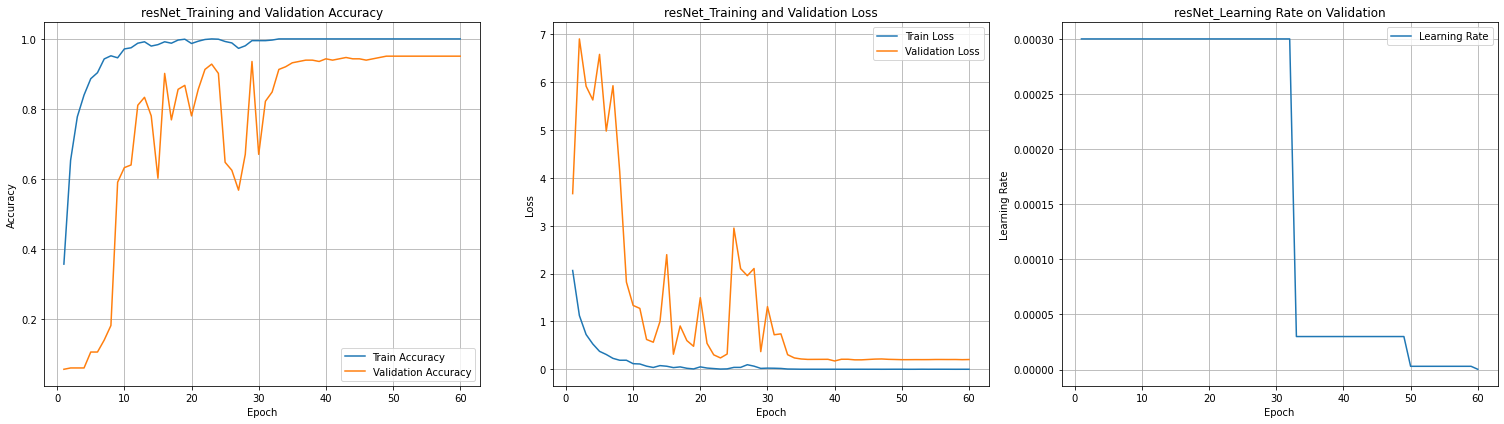

In [18]:
train_classifier(
    model,
    Model,
    save_path,
    EPOCHS,
    learning_rate,
    train_data,
    train_label,
    test_data,
    test_label,
    batch_size
)

# Online Evaluation

In [19]:
from tensorflow import keras
import editdistance



def load_model(save_path):
    SAVE_PATH_model = save_path + '/Model'
    print(save_path)
    model = keras.models.load_model(SAVE_PATH_model, custom_objects={'tf': tf})
    print('loaded model from {}'.format(save_path))
    return model

def online_rec(model,max_length, window_step, input_test):
    window_width = max_length
    outputs_list = []
    y_pred_list = []
    y_pred_value_list = []

    for window in np.arange(0, int(len(input_test) - window_width) + 1, window_step):
        window = int(window)

        input_slice = np.expand_dims(input_test[window:window + window_width], axis=0)

        Data = tf.data.Dataset.from_tensor_slices(
            (input_slice)
        )
        Data = Data.batch(1).prefetch(buffer_size=1)

        outputs = model.predict(Data, verbose=0)
        outputs_softmax = tf.nn.softmax(outputs)
        y_pred = np.argmax(outputs_softmax, axis=1)
        y_pred_value = np.max(outputs_softmax)

        outputs_list.append(outputs_softmax)
        y_pred_list.append(int(y_pred))
        y_pred_value_list.append(float(y_pred_value))

    return y_pred_list, outputs_list, y_pred_value_list

def online_rec2(model, max_length, window_step, input_test, num_frames_history=5, smoothing_method='simple_average', smoothing_factor=0.5):
    window_width = max_length
    outputs_list = []
    y_pred_list = []
    y_pred_value_list = []
    history_queue = deque(maxlen=num_frames_history)

    for window in np.arange(0, int(len(input_test) - window_width) + 1, window_step):
        window = int(window)

        input_slice = np.expand_dims(input_test[window:window + window_width], axis=0)

        Data = tf.data.Dataset.from_tensor_slices(
            (input_slice)
        )
        Data = Data.batch(1).prefetch(buffer_size=1)

        outputs = model.predict(Data, verbose=0)
        outputs_softmax = tf.nn.softmax(outputs)
        y_pred = np.argmax(outputs_softmax, axis=1)
        y_pred_value = np.max(outputs_softmax)

        # 平滑处理
        if smoothing_method == 'simple_average':
            if history_queue:
                avg_probs = np.mean(np.array(history_queue), axis=0)
                smoothed_probs = (avg_probs + outputs_softmax.numpy()) / 2  # 简单平均
            else:
                smoothed_probs = outputs_softmax.numpy()
        elif smoothing_method == 'exponential_smoothing':
            if history_queue:
                avg_probs = np.mean(np.array(history_queue), axis=0)
                smoothed_probs = smoothing_factor * avg_probs + (1 - smoothing_factor) * outputs_softmax.numpy()  # 指数加权平均
            else:
                smoothed_probs = outputs_softmax.numpy()
        else:
            raise ValueError("Unsupported smoothing method.")

        history_queue.append(outputs_softmax.numpy())

        outputs_list.append(smoothed_probs)
        y_pred_list.append(int(y_pred))
        y_pred_value_list.append(float(y_pred_value))

    return y_pred_list, outputs_list, y_pred_value_list


def eval_accuracy_nttd(y_pred_list, y_true, y_pred_value_list, threshold=0.6, recur_threshold=20,max = 0.21, min = 0.08):
    pred_list = []
    y_pred_value_list_ = (np.array(y_pred_value_list) - min) / (max - min)

    recur = 0
    frame_idx = []
    y_pred_ = y_pred_list[0]
    for i, value in enumerate(y_pred_value_list_):

        if value > threshold:
            recur += 1
            if recur > recur_threshold:
                y_pred = int(y_pred_list[i])
                if y_pred != y_pred_:
                    if y_pred != 0:
                        y_pred_ = y_pred
                        frame_idx.append(i)
                        frame_idx.append(i + 1)
                        pred_list.append(y_pred)
                        recur = 0

    y_pred = np.asarray(pred_list, dtype=np.int64)

    y_true = np.asarray(y_true, dtype=np.int64)

    accuracy = 1 - editdistance.eval(y_pred.tostring(), y_true.tostring()) / len(y_true.tostring())

    print('Pred {}'.format(y_pred))
    print('True {}'.format(y_true))
    print('Accuracy {}'.format(accuracy))

    return y_pred, y_true, accuracy, frame_idx


def evaluate_NTtD(classes,frame_idx,frame_sequence,y_true,y_pred):
    frame_pred = (np.array(frame_idx) + 300)[::2]
    frame_true = frame_sequence
    for j, b in enumerate(y_true):
        for i, a in enumerate(y_pred):
            start = frame_true[j * 2]
            end = frame_true[j * 2 + 1]
            #         print(frame_pred[i])

            if a == b and start < frame_pred[i] < end:
                NTtD = (frame_pred[i] - start + 1) / (end - start + 1)
                print('{} is recognized correctly at {} seconds, with NTtD {}'.format(classes[b].upper(),
                                                                                      frame_pred[i] / 72, NTtD))


def evaluate_NTtD_2(classes, frame_idx, frame_sequence, y_true, y_pred):
    frame_pred = (np.array(frame_idx) + 300)[::2]
    frame_true = frame_sequence
    
    print("frame_pred:", frame_pred)
    print("frame_true:", frame_true)
    
    for j, b in enumerate(y_true):
        print("Processing true label:", b)
        for i, a in enumerate(y_pred):
            start = frame_true[j * 2]
            end = frame_true[j * 2 + 1]
            print("Checking predicted label:", a, "with true label:", b)
            print("Predicted frame:", frame_pred[i], "True frame range:", start, "-", end)
            
            if a == b and start < frame_pred[i] < end:
                NTtD = (frame_pred[i] - start + 1) / (end - start + 1)
                print('{} is recognized correctly at {} seconds, with NTtD {}'.format(
                    classes[b].upper(), frame_pred[i] / 72, NTtD))                

                
def evaluate_NTtD_3(classes, frame_idx, frame_sequence, y_true, y_pred):
    frame_pred = (np.array(frame_idx)+100 )[::2]
    frame_true = frame_sequence
    
    print("frame_idx:", frame_idx)
    print("frame_pred:", frame_pred)
    print("frame_true:", frame_true)
    
    for j, b in enumerate(y_true):
        print("Processing true label:", b)
        for i, a in enumerate(y_pred):
            start = frame_true[j * 2]
            end = frame_true[j * 2 + 1]
            print("Checking predicted label:", a, "with true label:", b)
            print("Predicted frame:", frame_pred[i], "True frame range:", start, "-", end)
            
            if a == b and start < frame_pred[i] < end:
                NTtD = (frame_pred[i] - start + 1) / (end - start + 1)
                print('{} is recognized correctly at {} seconds, with NTtD {}'.format(
                    classes[b].upper(), frame_pred[i] / 72, NTtD))                
                
                

"""
def evaluate_NTtD(classes, frame_idx, frame_sequence, y_true, y_pred, frame_rate=72, time_window=4, threshold=0.2):
    # 转换预测帧为秒，并考虑时间窗口
    frame_pred = (np.array(frame_idx) + 300)[::2]  # 每个预测帧+300
    frame_true = frame_sequence
    
    # 平滑预测结果，计算时间窗口内的预测结果
    smoothed_predictions = []
    window_length = int(time_window * frame_rate)  # 时间窗口长度，单位为帧数
    for i in range(0, len(frame_pred) - window_length + 1, window_length):
        window = y_pred[i:i + window_length]
        most_common_pred = max(set(window), key=window.count)  # 窗口内最常见的预测结果
        smoothed_predictions.append(most_common_pred)
    
    # 过滤预测结果，仅保留置信度高于阈值的预测结果
    filtered_predictions = []
    for i, pred in enumerate(smoothed_predictions):
        if pred >= threshold:
            filtered_predictions.append((frame_pred[i], pred))
    
    correct_predictions = []  # 用于存储正确预测的手势类别和NTtD
    
    for j, true_label in enumerate(y_true):
        start = frame_true[j * 2]
        end = frame_true[j * 2 + 1]
        
        for frame_time, pred_label in filtered_predictions:
            if pred_label == true_label and start <= frame_time <= end:
                NTtD = (frame_time - start + 1) / (end - start + 1)
                correct_predictions.append((classes[true_label].upper(), frame_time / frame_rate, NTtD))
                break  # 找到匹配的预测后退出内循环
    
    # 输出每个正确识别的手势类别及其NTtD
    for gesture, time_sec, NTtD in correct_predictions:
        print('{} is recognized correctly at {} seconds, with NTtD {}'.format(gesture, time_sec, NTtD))



"""
"""
def evaluate_NTtD(classes, frame_idx, frame_sequence, y_true, y_pred_values, y_pred_classes, frame_rate=72, time_window=5, confidence_threshold=0.2):
    frame_pred = (np.array(frame_idx) + 300)[::2]
    frame_true = frame_sequence

    # 设置时间窗口相关参数
    window_length = int(time_window * frame_rate)
    stable_predictions = []

    for i in range(0, len(frame_pred) - window_length + 1, window_length):
        window_pred_values = y_pred_values[i:i + window_length]
        window_pred_classes = y_pred_classes[i:i + window_length]

        # 计算窗口内每个类别的平均预测概率
        avg_confidences = []
        for c in range(len(classes)):
            class_confidences = [window_pred_values[j][c] for j in range(window_length)]
            avg_confidence = np.mean(class_confidences)
            avg_confidences.append(avg_confidence)

        # 判断是否有类别的平均预测概率超过阈值
        selected_classes = []
        for c in range(len(classes)):
            if avg_confidences[c] > confidence_threshold:
                selected_classes.append(c)

        # 如果有类别的预测概率超过阈值，则输出这些类别
        if len(selected_classes) > 0:
            most_confident_class = np.argmax(avg_confidences)
            stable_predictions.append((frame_pred[i], most_confident_class))

    correct_predictions = []
    for j, true_label in enumerate(y_true):
        start = frame_true[j * 2]
        end = frame_true[j * 2 + 1]

        for frame_time, pred_label in stable_predictions:
            if pred_label == true_label and start <= frame_time <= end:
                NTtD = (frame_time - start + 1) / (end - start + 1)
                correct_predictions.append((classes[true_label].upper(), frame_time / frame_rate, NTtD))
                break

    for gesture, time_sec, NTtD in correct_predictions:
        print('{} is recognized correctly at {} seconds, with NTtD {}'.format(gesture, time_sec, NTtD))

    return stable_predictions, correct_predictions
"""

"""

def evaluate_NTtD(classes, frame_idx, frame_sequence, y_true, y_pred, frame_rate=72, time_window=4, stability_threshold=0.2):
    frame_pred = (np.array(frame_idx) + 300)[::2]
    frame_true = frame_sequence

    # 平滑预测结果，计算时间窗口内的预测结果和稳定性
    smoothed_predictions = []
    stability_scores = []
    window_length = int(time_window * frame_rate)
    
    for i in range(0, len(frame_pred) - window_length + 1, window_length):
        window = y_pred[i:i + window_length]
        most_common_pred = max(set(window), key=window.count)
        smoothed_predictions.append(most_common_pred)
        
        # 计算预测变化性（标准差）
        stability_score = np.std(window)
        stability_scores.append(stability_score)
    
    # 过滤预测结果，仅保留稳定性高于阈值的预测结果
    filtered_predictions = []
    for i, pred in enumerate(smoothed_predictions):
        if stability_scores[i] < stability_threshold:
            filtered_predictions.append((frame_pred[i], pred))
        else:
            filtered_predictions.append((frame_pred[i], 0))  # 设置为0表示空白帧
    
    correct_predictions = []
    for j, true_label in enumerate(y_true):
        start = frame_true[j * 2]
        end = frame_true[j * 2 + 1]
        for frame_time, pred_label in filtered_predictions:
            if pred_label == true_label and start <= frame_time <= end:
                NTtD = (frame_time - start + 1) / (end - start + 1)
                correct_predictions.append((classes[true_label].upper(), frame_time / frame_rate, NTtD))
                break
    
    for gesture, time_sec, NTtD in correct_predictions:
        print('{} is recognized correctly at {} seconds, with NTtD {}'.format(gesture, time_sec, NTtD))

"""   
        
        
def online_plot(outputs_list, input_test, input_label, frame_sequence):
    outputs_list_ = np.squeeze(outputs_list, axis=1)
    color_list_morandi = [
    '#DB7272', '#C6A550', '#A1D4A2', '#3C518F',
    '#38917E', '#A47DC0', '#DEAA87', '#E9DDAF', '#93AC93',
    '#2B5863', '#6A8078', '#9D9D9D', '#F27873', '#FFD373',
    '#008A45', '#80C5A2', '#5F5F5E', '#468BCA', '#7DD2F6',
    '#B384BA', '#D9C2DD', '#1F77B4', '#DAA628', '#47A1A2',
    '#282973', '#708090', '#F9BFCB', '#989ED9', '#4D0085']
    
    
    
    list_ = np.zeros((17, len(input_test)))
    for i, index in enumerate(frame_sequence):
        if i % 2 == 0:
            list_[input_label[int(i / 2)]][frame_sequence[i]:frame_sequence[i + 1]] = 1

    list__ = np.transpose(list_)
    x_axis = np.arange(np.shape(outputs_list_)[0])
    x_axis_tile = np.tile(x_axis, (np.shape(outputs_list_)[1], 1))
    x_axis_tile_t = np.transpose(x_axis_tile)

    fig, (ax1, ax2) = plt.subplots(figsize=(20, 5), ncols=2, sharex=True)

    for i in range(17):
        if i == 0:
            continue
        ax1.plot(np.concatenate((np.arange(300) / 72, x_axis_tile_t[:, i] / 72 + 300 / 72)),
                 np.concatenate((np.ones(300) * np.mean(outputs_list_[:, 0]), outputs_list_[:, i])), color_list_morandi[i % len(color_list_morandi)])
        ax1.set_title(f"{model_name}_Model gesture category prediction")
        
        
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('prediction Labels') 

    for i in range(17):
        if i == 0:
            continue
        ax2.plot(np.concatenate((np.arange(300) / 72, x_axis_tile_t[:-1, i] / 72 + 300 / 72))[:len(list__)],
                 list__[:, i], color_list_morandi[i % len(color_list_morandi)])
        ax2.set_title('Actual gesture labels')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('True Labels')

    plt.tight_layout()
    plt.savefig(f"{model_name}_Model gesture category prediction")  # 设置你想要的图片名称  
    plt.show()

    # fig.savefig('plot/online_{}.png'.format('_'.join([str(i) for i in input_label])))

In [20]:
from tensorflow import keras
from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score,
    f1_score
)


def eval_classifier(Model,SAVE_PATH,test_data, test_label, batch_size):

    ## test load
    Data,_,_, y_true  = getDataTest(test_data, test_label, batch_size)
    SAVE_PATH_model = './Model'
    model = keras.models.load_model(SAVE_PATH_model, custom_objects={'tf': tf})
    print('Model loaded: {}'.format(Model))

    out = model.predict(Data, verbose=1)
    y_pred = np.argmax(out,axis=1)
    y_true = np.array(y_true)
    y_true = y_true.astype(np.int32)


    print('Real Data for validation')
    print('Accuracy: {:.4f}'.format(accuracy_score(y_pred, y_true)))
    print('Precision: {:.4f}'.format(precision_score(y_pred, y_true, average='macro')))
    print('Recall: {:.4f}'.format(recall_score(y_pred, y_true, average='macro')))
    print('F1 score: {:.4f}'.format(f1_score(y_pred, y_true, average='macro')))
    print('-------------------------------------------------------------------')
    print('\n')
    cm = confusion_matrix(y_pred, y_true)
    np.save(SAVE_PATH + '/confusion_matrix.npy', cm)

    return out,[accuracy_score(y_pred, y_true), precision_score(y_pred, y_true, average='macro'),
            recall_score(y_pred, y_true, average='macro'), f1_score(y_pred, y_true, average='macro') ]


def confusion_matrix_(cm,save_path,classes):
    cm = np.load(save_path + '/confusion_matrix.npy')


    target_names = list(classes)
    title = 'Confusion matrix'
    cmap = None
    normalize = True

    accuracy = np.trace(cm) / float(np.sum(cm))
    # np.save(SAVE_PATH+ 'confusion_matrix.npy',cm)
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if 'Times New Roman' in plt.rcParams['font.family']:
        plt.rcParams['font.family'] = 'Times New Roman'
    else:
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = 'Times New Roman'
    plt.figure(figsize=(10, 10))
    # plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title, fontsize=30)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90, fontsize=10)
        plt.yticks(tick_marks, target_names, fontsize=10)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 10 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel(f"{model_name}_True label", fontsize=12)
    plt.xlabel(f"{model_name}_Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}", fontsize=12)
    plt.imshow(cm, cmap=cmap)
    # plt.grid(None)
    plt.tight_layout()
    plt.savefig(f"{model_name}_confusion_matrix.png")  # 设置你想要的图片名称  
    # plt.show()
    # plt.savefig('shrec21_confusion_matrix.pdf')
    # plt.close()


In [21]:
save_path = main_folder
model = load_model(save_path)

./
loaded model from ./


In [22]:
# evaluating
_,_ = eval_classifier(Model,save_path, test_data, test_label,batch_size)

Model loaded: resNet
12/12 [==============================] - 1s 30ms/step
Real Data for validation
Accuracy: 0.9519
Precision: 0.9522
Recall: 0.9561
F1 score: 0.9525
-------------------------------------------------------------------




In [23]:
classes = ['ONE','TWO','THREE','FOUR','OK','MENU', 'LEFT','RIGHT','CIRCLE','V','CROSS','GRAB','PINCH','TAP','DENY', 'KNOB','EXPAND']

In [24]:
cm = np.load(save_path + '/confusion_matrix.npy')
cm1 = np.concatenate(([[0 , 0 ,0  ,0 , 0 , 0  ,0 , 0 , 0 , 0 , 0 , 0,  0 , 0 , 0 , 0  ,0]],cm),0)
cm2=np.concatenate(([[16 , 0 ,0  ,0 , 0 , 0  ,0 , 0 , 0 , 0 , 0 , 0,  0 , 0 , 0 , 0  ,0,0]],cm1.T),0).T

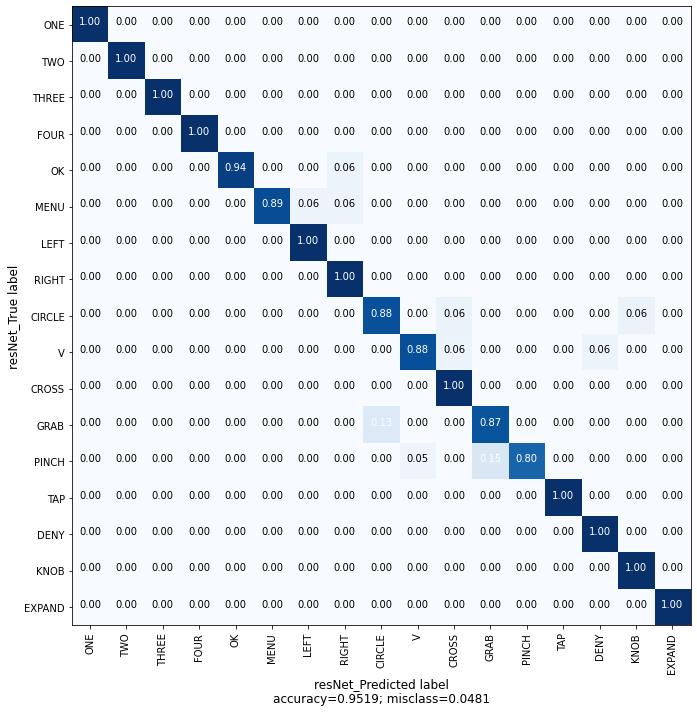

In [25]:
confusion_matrix_(cm2,save_path,classes)

In [26]:
def read_annotation_idx(fname_,idx):
    gesture_name = ['ONE','TWO','THREE','FOUR','OK','MENU', 'LEFT',
                    'RIGHT','CIRCLE','V','CROSS','GRAB','PINCH','TAP','DENY', 'KNOB','EXPAND']
    with open(fname_) as f:
        lines = f.readlines()

    gesture_name_list = []
    start_idx_list = []
    end_idx_list = []
    annotation_idx_list = []
    for i in range(len(lines)):

        gesture_name_list.append(lines[i].split(';')[1:-1][::3])
        start_idx_list.append(lines[i].split(';')[2:-1][::3])
        end_idx_list.append(lines[i].split(';')[0:-1][::3][1:])
        annotation_idx_list.append(int(lines[i].split(';')[0]))

    gesture_name_list = [x for _, x in sorted(zip(annotation_idx_list, gesture_name_list))]
    start_idx_list = [x for _, x in sorted(zip(annotation_idx_list, start_idx_list))]
    end_idx_list = [x for _, x in sorted(zip(annotation_idx_list, end_idx_list))]

    label = gesture_name_list[idx]
    start_idx_list_ = start_idx_list[idx]
    end_idx_list_ = end_idx_list[idx]
    frame_sequence = [[int(start_idx_list_[i]),int(end_idx_list_[i])] for i in range(len(start_idx_list_))]

    return label, frame_sequence

In [27]:
pos = True
quat = True

fname_ = '{}/test_set/annotations_revised.txt'.format(main_folder)

idx = 109
filename = '{}/test_set/sequences/{}.txt'.format(main_folder,idx)
data_ = genfromtxt(filename, delimiter=';')
data = np.delete(data_, -1, axis=1)
# 180;THREE;185;303;LEFT;514;534;PINCH;815;843;ONE;1047;1112;KNOB;1298;1320;
data = select_joint(selected_joint,data,pos, quat)
label, frame_sequence = read_annotation_idx(fname_,idx-109)
frame_sequence = np.reshape(frame_sequence,(-1))

y_true = [classes.index(x) for x in label]
print(frame_sequence)
print(y_true)
print(label)

[ 280  449  741  778 1382 1393 1764 1784]
[14, 11, 12, 16]
['DENY', 'GRAB', 'PINCH', 'EXPAND']


In [28]:
import tqdm
from collections import deque
def online_rec(model,max_length, window_step, input_test):
    window_width = max_length
    outputs_list = []
    y_pred_list = []
    y_pred_value_list = []

    for window in tqdm.tqdm(np.arange(0, int(len(input_test) - window_width) + 1, window_step)):
        window = int(window)

        input_slice = np.expand_dims(input_test[window:window + window_width], axis=0)

        Data = tf.data.Dataset.from_tensor_slices(
            (input_slice)
        )
        Data = Data.batch(1).prefetch(buffer_size=1)

        outputs = model.predict(Data, verbose=0)
        outputs_softmax = tf.nn.softmax(outputs)
        y_pred = np.argmax(outputs_softmax, axis=1)
        y_pred_value = np.max(outputs_softmax)

        outputs_list.append(outputs_softmax)
        y_pred_list.append(int(y_pred))
        y_pred_value_list.append(float(y_pred_value))

    return y_pred_list, outputs_list, y_pred_value_list

def online_rec2(model, max_length, window_step, input_test, num_frames_history=5):
    window_width = max_length
    outputs_list = []
    y_pred_list = []
    y_pred_value_list = []
    history_queue = []

    for window in tqdm.tqdm(np.arange(0, int(len(input_test) - window_width) + 1, window_step)):
        window = int(window)

        input_slice = np.expand_dims(input_test[window:window + window_width], axis=0)

        Data = tf.data.Dataset.from_tensor_slices(
            (input_slice)
        )
        Data = Data.batch(1).prefetch(buffer_size=1)

        outputs = model.predict(Data, verbose=0)
        outputs_softmax = tf.nn.softmax(outputs)
        y_pred = np.argmax(outputs_softmax, axis=1)
        y_pred_value = np.max(outputs_softmax)

        # 将当前帧的预测概率添加到历史队列
        history_queue.append(outputs_softmax.numpy())

        # 如果历史队列超过指定的历史帧数，则移除最旧的一帧
        if len(history_queue) > num_frames_history:
            history_queue.pop(0)

        # 计算移动平均
        smoothed_probs = np.mean(np.array(history_queue), axis=0)

        outputs_list.append(smoothed_probs)
        y_pred_list.append(int(y_pred))
        y_pred_value_list.append(float(y_pred_value))

    return y_pred_list, outputs_list, y_pred_value_list

In [29]:
window_step = 1
y_pred_list, outputs_list, y_pred_value_list = online_rec2(model,max_length, window_step, data)


100%|██████████| 1789/1789 [00:30<00:00, 58.15it/s]


In [30]:
def smooth_output(outputs_list, Dataframe_Size, threshold=0.1, mask_length=72):
    outputs_array = np.array(outputs_list)
    outputs_array_max = np.zeros_like(outputs_array)  
    
    # 将小于阈值的元素设为0
    max_indices = np.argmax(outputs_array, axis=2)  # 找到每一帧的最大概率的类别索引
    rows = np.arange(outputs_array.shape[0])
    outputs_array_max[rows, 0, max_indices[:, 0]] = outputs_array[rows, 0, max_indices[:, 0]]  # 只保留最大概率的类别值


    max_category = np.argmax(outputs_array_max, axis=2)

    # 初始化一个标记数组，标记哪些帧需要置零
    mask = np.zeros(outputs_array_max.shape, dtype=bool)

    for i in range(1, Dataframe_Size):
        if i < mask_length:
            start = 0
        else:
            start = i - mask_length
        if np.any(max_category[start:i] != max_category[i]):
            mask[i, 0, :] = True

    # 将需要过滤的帧置零
    outputs_array_max[mask] = 0
    
    return outputs_array_max
    
    

In [31]:
def smooth_output_2(outputs_list, Dataframe_Size, threshold=0.1, mask_length=72, alpha=2, smoothing_window=20):

    outputs_array = np.array(outputs_list)  # 将列表转换为 NumPy 数组
    outputs_array_max = np.zeros_like(outputs_array)  # 创建一个和输入数组相同形状的全零数组
    
    # 将小于阈值的元素设为0
    max_indices = np.argmax(outputs_array, axis=2)  # 找到每一帧的最大概率的类别索引
    rows = np.arange(outputs_array.shape[0])
    outputs_array_max[rows, 0, max_indices[:, 0]] = outputs_array[rows, 0, max_indices[:, 0]]  # 只保留最大概率的类别值
    
    # 使用指数函数调整概率分布，增强高概率值的影响，减弱低概率值的影响
    smoothed_outputs = 1 / (1 + np.exp(-alpha * (outputs_array_max - 0.5)))  # 对每个预测概率进行变换
    
    # 滑动平均处理
    smoothed_outputs = smooth_with_window(smoothed_outputs, window_size=smoothing_window)
    
    # 归一化处理，确保每一帧的概率总和为1
    smoothed_outputs /= np.sum(smoothed_outputs, axis=-1, keepdims=True)
    
    # 将小于阈值的元素设为0
    max_indices = np.argmax(outputs_array, axis=2)  # 找到每一帧的最大概率的类别索引
    rows = np.arange(outputs_array.shape[0])
    outputs_array_max[rows, 0, max_indices[:, 0]] = outputs_array[rows, 0, max_indices[:, 0]]  # 只保留最大概率的类别值
    
    # 检查在 mask_length 帧内是否发生概率变化，将变化的帧置零
    for i in range(1, Dataframe_Size):
        if i < mask_length:
            start = 0
        else:
            start = i - mask_length
        if np.any(np.abs(smoothed_outputs[start:i] - smoothed_outputs[i]) > threshold):
            smoothed_outputs[i] = 0
    return smoothed_outputs


def smooth_with_window(outputs, window_size=5):

    smoothed_outputs = np.zeros_like(outputs)
    for i in range(outputs.shape[0]):
        start = max(0, i - window_size // 2)
        end = min(outputs.shape[0], i + window_size // 2 + 1)
        smoothed_outputs[i] = np.mean(outputs[start:end], axis=0)
    return smoothed_outputs


def optimize_smooth_output(outputs_list):
    outputs_array = np.array(outputs_list)
    
    # 找到每帧最大概率的类别索引
    max_indices = np.argmax(outputs_array, axis=2)
    
    # 创建一个新的数组，将除了最大概率类别的其他类别置为0
    optimized_outputs = np.zeros_like(outputs_array)
    rows = np.arange(outputs_array.shape[0])
    optimized_outputs[rows, 0, max_indices[:, 0]] = outputs_array[rows, 0, max_indices[:, 0]]
    
    return optimized_outputs

def optimize_smooth_output3(outputs_list):
    outputs_array = np.array(outputs_list)
    
    # 找到每帧最大概率的类别索引
    max_indices = np.argmax(outputs_array, axis=2)
    
    # 创建一个新的数组，将除了最大概率类别的其他类别置为0
    optimized_outputs = np.zeros_like(outputs_array)
    rows = np.arange(outputs_array.shape[0])
    optimized_outputs[rows, 0, max_indices[:, 0]] = outputs_array[rows, 0, max_indices[:, 0]]
    
    for c in range(outputs_array.shape[2]):
        # 找到每个类别 c 在所有帧的概率
        probs = outputs_array[:, 0, c]
        
        threshold = np.percentile(probs, 100 - (100 / 18))
        
        # 将小于阈值的概率置为0
        optimized_outputs[:, 0, c] *= (probs >= threshold)
    
    return optimized_outputs

In [38]:
y_pred, y_true, accuracy, frame_idx= eval_accuracy_nttd(y_pred_list, y_true, y_pred_value_list, threshold=0.5, recur_threshold=20, max = 0.21, min = 0.08)

Pred [14 11 12 16]
True [14 11 12 16]
Accuracy 1.0


/tmp/ipykernel_415378/187641178.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  accuracy = 1 - editdistance.eval(y_pred.tostring(), y_true.tostring()) / len(y_true.tostring())


In [39]:
evaluate_NTtD_2(classes,frame_idx,frame_sequence,y_true,y_pred)

frame_pred: [ 543 1029 1597 2017]
frame_true: [ 280  449  741  778 1382 1393 1764 1784]
Processing true label: 14
Checking predicted label: 14 with true label: 14
Predicted frame: 543 True frame range: 280 - 449
Checking predicted label: 11 with true label: 14
Predicted frame: 1029 True frame range: 280 - 449
Checking predicted label: 12 with true label: 14
Predicted frame: 1597 True frame range: 280 - 449
Checking predicted label: 16 with true label: 14
Predicted frame: 2017 True frame range: 280 - 449
Processing true label: 11
Checking predicted label: 14 with true label: 11
Predicted frame: 543 True frame range: 741 - 778
Checking predicted label: 11 with true label: 11
Predicted frame: 1029 True frame range: 741 - 778
Checking predicted label: 12 with true label: 11
Predicted frame: 1597 True frame range: 741 - 778
Checking predicted label: 16 with true label: 11
Predicted frame: 2017 True frame range: 741 - 778
Processing true label: 12
Checking predicted label: 14 with true label

In [40]:
evaluate_NTtD_3(classes,frame_idx,frame_sequence,y_true,y_pred)

frame_idx: [243, 244, 729, 730, 1297, 1298, 1717, 1718]
frame_pred: [ 343  829 1397 1817]
frame_true: [ 280  449  741  778 1382 1393 1764 1784]
Processing true label: 14
Checking predicted label: 14 with true label: 14
Predicted frame: 343 True frame range: 280 - 449
DENY is recognized correctly at 4.763888888888889 seconds, with NTtD 0.3764705882352941
Checking predicted label: 11 with true label: 14
Predicted frame: 829 True frame range: 280 - 449
Checking predicted label: 12 with true label: 14
Predicted frame: 1397 True frame range: 280 - 449
Checking predicted label: 16 with true label: 14
Predicted frame: 1817 True frame range: 280 - 449
Processing true label: 11
Checking predicted label: 14 with true label: 11
Predicted frame: 343 True frame range: 741 - 778
Checking predicted label: 11 with true label: 11
Predicted frame: 829 True frame range: 741 - 778
Checking predicted label: 12 with true label: 11
Predicted frame: 1397 True frame range: 741 - 778
Checking predicted label: 1

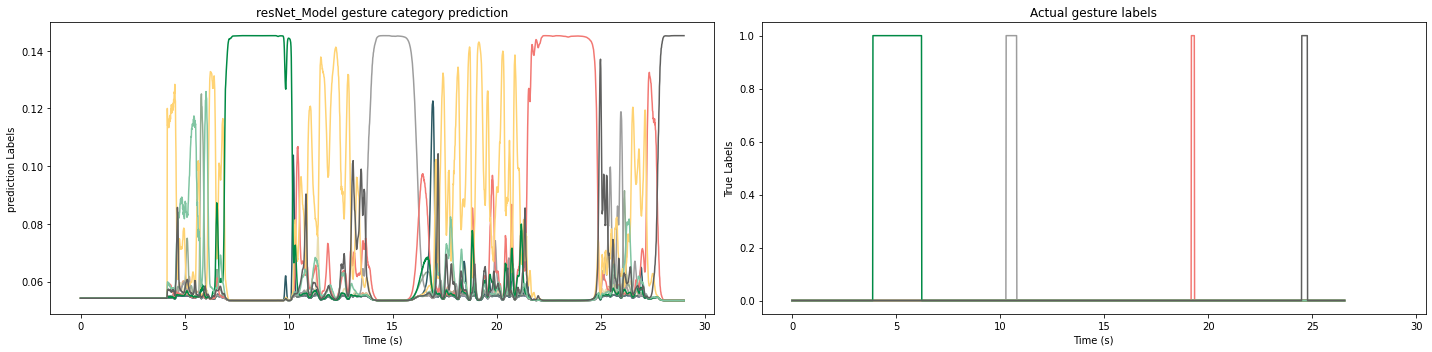

In [41]:
online_plot(outputs_list, data,y_true, frame_sequence)

In [42]:

outputs_array=smooth_output_2(outputs_list,threshold=0.1, mask_length=10,Dataframe_Size=frame_sequence.shape[0], alpha=2,smoothing_window=72)


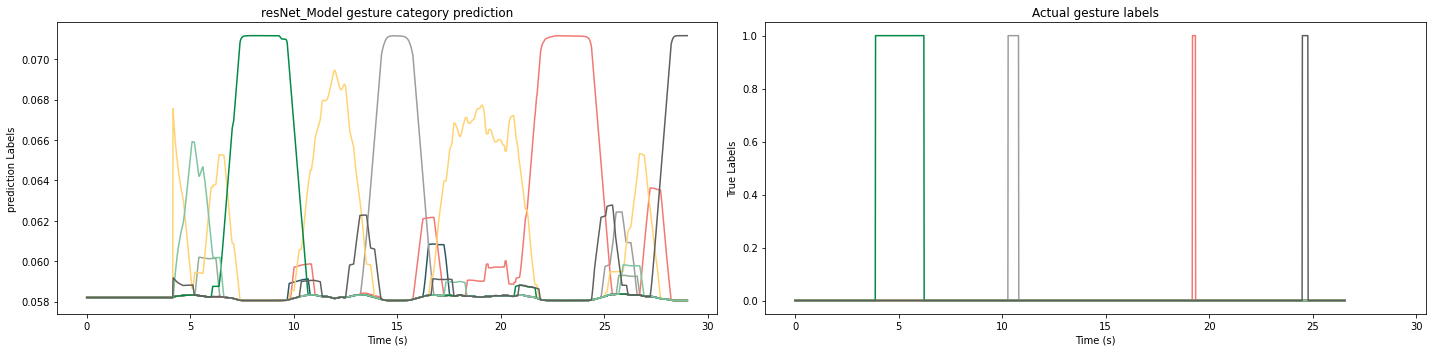

In [43]:
online_plot(outputs_array, data,y_true, frame_sequence)